# 이동평균선을 이용한 Simple trading strategy 

- fast signal (단기 이동평균) 이 slow signal (장기 이동평균)위에 있으면 1 주 보유, 아래에 있으면 0 주 보유 전략  
- 종가에 매수, 매도 한다고 가정. 거래비용 없다고 가정.

- MA10 >= MA50 : 1 주 보유 (매수 or hold), MA10 < MA50 : 0 주 보유 (매도 or no action)  
 
- Daily Profit 계산

- 누적 수익 계산

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import FinanceDataReader as fdr

short = 10
long = 50  # 100, 200

In [3]:
ms = fdr.DataReader("MSFT", start="20200101")  #Microsoft
ms.head()

,Open,High,Low,Close,Volume,Adj Close
2019-12-31,156.770004,157.770004,156.449997,157.699997,18369400,151.139694
2020-01-02,158.779999,160.729996,158.330002,160.619995,22622100,153.938248
2020-01-03,158.320007,159.949997,158.059998,158.619995,21116200,152.021423
2020-01-06,157.080002,159.100006,156.509995,159.029999,20813700,152.414337
2020-01-07,159.320007,159.669998,157.320007,157.580002,21634100,151.024689


In [4]:
ms.drop(['High', 'Low', 'Open', 'Volume', 'Close'], axis=1, inplace=True)

In [5]:
# 단기 및 장기 이동평균(MA_SHORT, MA_LONG) 계산
# 'Adj Close' 열을 기준으로 단기 이동평균(MA_SHORT)을 계산하고 데이터프레임에 추가합니다.
ms['MA_SHORT'] = ms['Adj Close'].rolling(short).mean()

# 'Adj Close' 열을 기준으로 장기 이동평균(MA_LONG)을 계산하고 데이터프레임에 추가합니다.
ms['MA_LONG'] = ms['Adj Close'].rolling(long).mean()

# 매매 신호(Shares)를 생성
# 각 날짜에 대해, 단기 이동평균(MA_SHORT)이 장기 이동평균(MA_LONG)보다 크거나 같으면 1(매수),
# 그렇지 않으면 0(매도)로 설정하여 'Shares' 열에 저장합니다.
ms['Shares'] = [1 if ms.loc[day, 'MA_SHORT'] >= ms.loc[day, 'MA_LONG'] 
                else 0 for day in ms.index]

ms.head()

,Adj Close,MA_SHORT,MA_LONG,Shares
2019-12-31,151.139694,NaN,NaN,0
2020-01-02,153.938248,NaN,NaN,0
2020-01-03,152.021423,NaN,NaN,0
2020-01-06,152.414337,NaN,NaN,0
2020-01-07,151.024689,NaN,NaN,0


In [6]:
ms.tail()

,Adj Close,MA_SHORT,MA_LONG,Shares
2024-09-09,405.720001,410.234003,426.569891,0
2024-09-10,414.200012,410.305005,425.930974,0
2024-09-11,423.040009,411.225006,425.273608,0
2024-09-12,427.000000,412.865005,424.644535,0
2024-09-13,430.589996,414.612006,424.057515,0


In [7]:
# 'Adj Close'(조정 종가)를 기준으로 다음 날의 종가(NextDay Close)를 생성
# shift(-1)은 데이터를 한 행씩 위로 이동시켜 다음 날의 종가 데이터를 가져옵니다.
ms['NextDay Close'] = ms['Adj Close'].shift(-1)

ms.head()

,Adj Close,MA_SHORT,MA_LONG,Shares,NextDay Close
2019-12-31,151.139694,NaN,NaN,0,153.938248
2020-01-02,153.938248,NaN,NaN,0,152.021423
2020-01-03,152.021423,NaN,NaN,0,152.414337
2020-01-06,152.414337,NaN,NaN,0,151.024689
2020-01-07,151.024689,NaN,NaN,0,153.430283


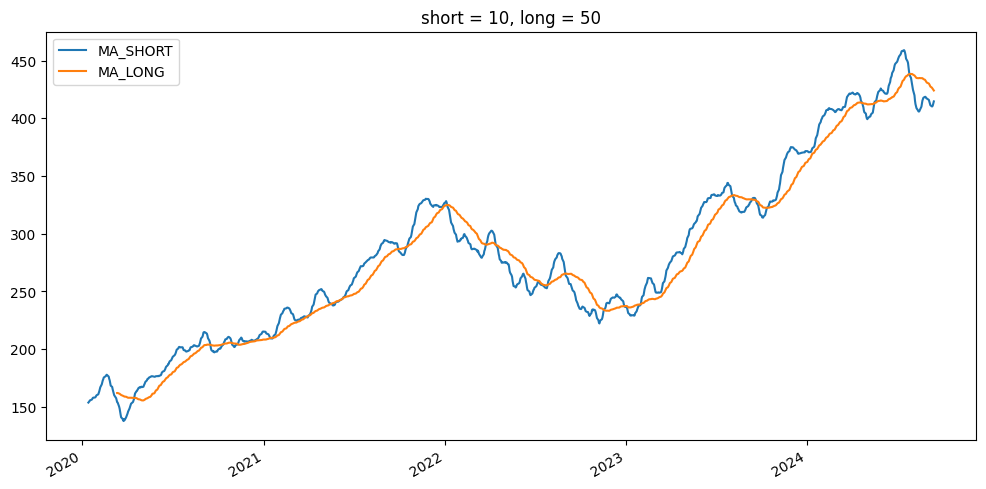

In [8]:
# 'MA_SHORT'와 'MA_LONG' 열을 시각화
# 단기 이동평균(MA_SHORT)과 장기 이동평균(MA_LONG)을 함께 플로팅합니다.
# 그래프 크기를 12x6으로 설정합니다.
ms[['MA_SHORT', 'MA_LONG']].plot(figsize=(12, 6))

# 그래프의 제목을 설정합니다. short와 long 변수 값을 제목에 포함시킵니다.
plt.title(f"short = {short}, long = {long}")

plt.show()

## Daily Profit

In [9]:
# 일일 수익(Daily Profit) 계산
# 매매 신호(Shares)가 1(매수)일 때, 다음 날의 종가(NextDay Close)와 당일 조정 종가(Adj Close)의 차이를 계산하여 수익을 구합니다.
# 매수 신호가 아닌 경우 수익은 0으로 설정합니다.
ms['Profit'] = [ms.loc[day, 'NextDay Close'] - ms.loc[day, 'Adj Close'] 
                if ms.loc[day, 'Shares'] == 1 else 0 for day in ms.index]

# 데이터프레임에서 100번째부터 104번째까지의 행을 출력하여 결과를 확인합니다.
ms.iloc[100:105]

,Adj Close,MA_SHORT,MA_LONG,Shares,NextDay Close,Profit
2020-05-26,174.977982,175.933971,161.637510,1,175.209259,0.231277
2020-05-27,175.209259,175.915363,162.538875,1,174.814133,-0.395126
2020-05-28,174.814133,176.122484,163.218030,1,176.597015,1.782883
2020-05-29,176.597015,176.432930,164.051432,1,176.192215,-0.404800
2020-06-01,176.192215,176.450151,164.832339,1,178.196701,2.004486


In [10]:
# 수익(Profit) 데이터에서 최소값, 최대값, 평균값을 계산합니다.
# min()은 최소 수익, max()는 최대 수익, mean()은 평균 수익을 계산합니다.
ms['Profit'].min(), ms['Profit'].max(), ms['Profit'].mean()

(-15.92132568359375, 19.71636962890625, 0.1081178768261059)

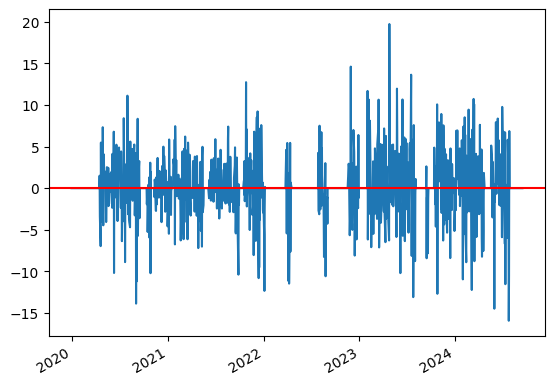

In [11]:
# 수익(Profit) 데이터를 플로팅하여 시각화
ms['Profit'].plot()

# y축 값이 0인 위치에 빨간색 수평선을 그립니다. 
# 빨간 선 위쪽은 수익을 낸 구간, 아래쪽은 손실을 본 구간을 나타냅니다.
plt.axhline(y=0, color='r')

plt.show()

## 누적 수익

In [12]:
# 'Profit' 열의 누적 합을 계산하여 'wealth'(누적 자산) 열에 저장합니다.
# cumsum() 함수는 각 날짜까지의 수익을 누적하여 자산의 증가량을 계산합니다.
ms['wealth'] = ms['Profit'].cumsum()

ms.tail()

,Adj Close,MA_SHORT,MA_LONG,Shares,NextDay Close,Profit,wealth
2024-09-09,405.720001,410.234003,426.569891,0,414.200012,0.0,128.011566
2024-09-10,414.200012,410.305005,425.930974,0,423.040009,0.0,128.011566
2024-09-11,423.040009,411.225006,425.273608,0,427.000000,0.0,128.011566
2024-09-12,427.000000,412.865005,424.644535,0,430.589996,0.0,128.011566
2024-09-13,430.589996,414.612006,424.057515,0,NaN,0.0,128.011566


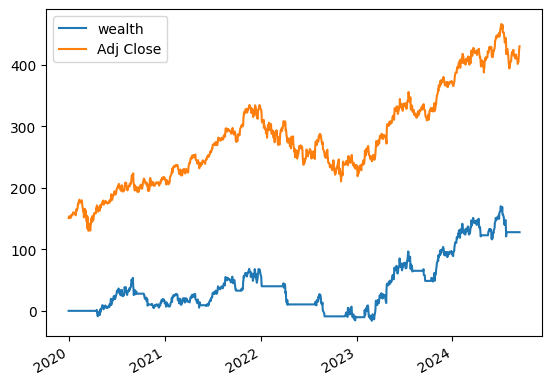

In [13]:
# 'wealth'(누적 자산)과 'Adj Close'(조정 종가) 열을 함께 시각화
# 'wealth'와 'Adj Close' 데이터를 동일한 그래프에 플로팅하여 자산의 누적 변화와 주가 변동을 비교합니다.
ms[['wealth', 'Adj Close']].plot()

plt.show()

MA_SHORT >= MA_LONG : 1 주 보유 (매수 or hold), MA_SHORT < MA_LONG : 0 주 보유
이 전략으로 1719일 동안 1주 매매로 얻은 수익 : 128.01 


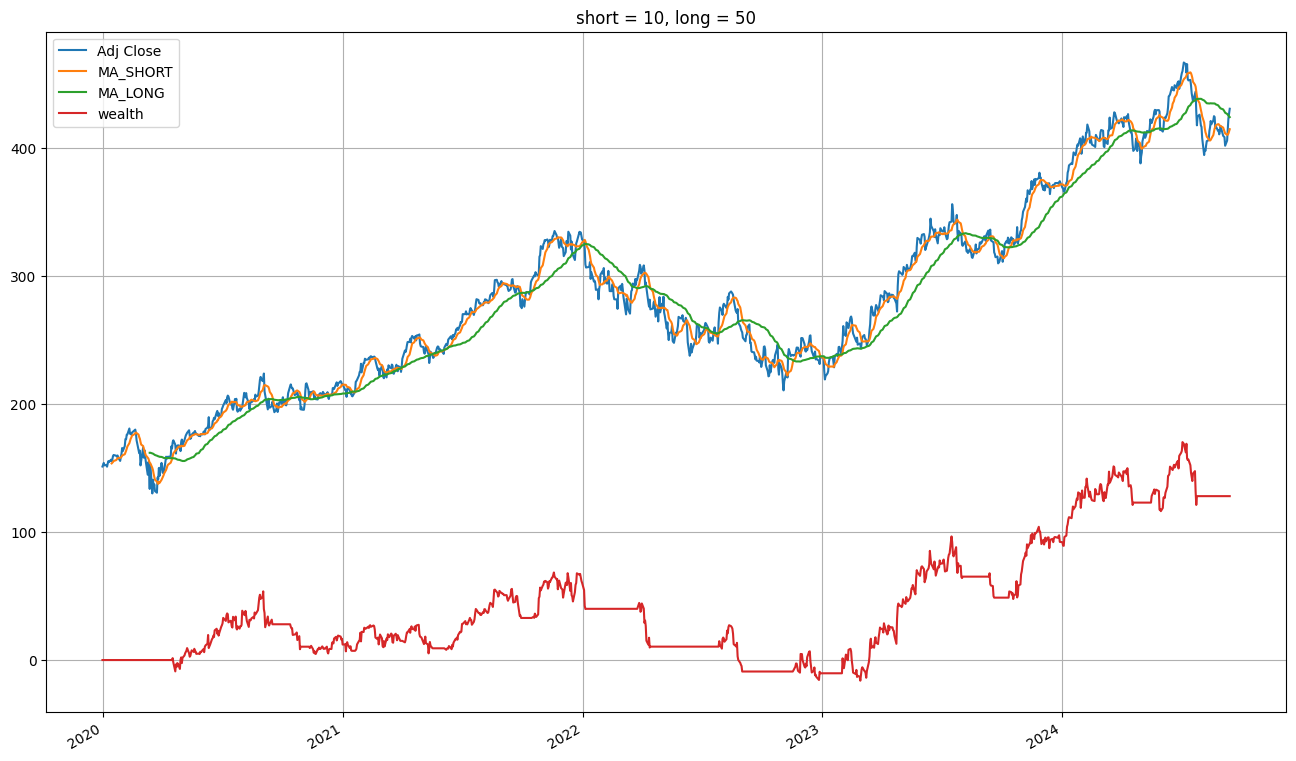

In [14]:
# 전체 기간 동안의 일수를 계산합니다.
n_days = len(pd.date_range(ms.index[0], ms.index[-1]))

# 매매 전략 설명
# MA_SHORT >= MA_LONG일 때는 1주 보유(매수 또는 홀드), MA_SHORT < MA_LONG일 때는 0주 보유(매도)를 의미합니다.
print('MA_SHORT >= MA_LONG : 1 주 보유 (매수 or hold), MA_SHORT < MA_LONG : 0 주 보유')

# 해당 전략으로 전체 기간 동안 얻은 수익을 출력합니다.
# ms.index[-2]는 마지막 날의 직전 날을 가리키며, 'wealth' 열의 값을 출력하여 수익을 확인합니다.
print(f"이 전략으로 {n_days}일 동안 1주 매매로 얻은 수익 : {ms.loc[ms.index[-2], 'wealth']:.2f} ")

# 'Adj Close', 'MA_SHORT', 'MA_LONG', 'wealth' 열을 함께 시각화
# 그래프 크기를 16x10으로 설정하고, 종가, 단기/장기 이동평균, 그리고 누적 자산 변화를 시각화합니다.
ms[['Adj Close', 'MA_SHORT', 'MA_LONG', 'wealth']].plot(figsize=(16, 10))

# 그래프 제목을 설정합니다. short와 long 변수 값을 제목에 포함시킵니다.
plt.title(f"short = {short}, long = {long}")

plt.grid()
plt.show()